In [1]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt 
from PIL import Image
from six import BytesIO
import numpy as np
import random
import glob

import tensorflow as tf

In [2]:
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

In [3]:
from utilities import plot_detection, read_image_to_numpy
from TFRecord_Generate_Parse import parse_tfexample

## Prepare data for training

In [4]:
## generate TF record if needed
Generate_TFRecord = False
if Generate_TFRecord:
    ## Generate TFRecord
    from TFRecord_Generate_Parse import create_tf_record
    
    
    output_file = 'data/sample_data/roof/valid.tfrecord'
    xml_dir = 'data/sample_data/roof/rawdata/valid'
    image_dir = 'data/sample_data/roof/rawdata/valid'
    image_suffix = 'tif'
    create_tf_record(output_file, xml_dir, image_dir, image_suffix = image_suffix)

#### Convert to training/validation dataset

In [5]:
name_label_mappings = {'roof': 1}

# By convention, our non-background classes start counting at 1.  
category_index = {}
for name, label in name_label_mappings.items():
    category_index[label] = {'id': label, 'name': name}

num_classes = len(name_label_mappings)

# shifts all classes by a certain number of indices; so this so that the model receives one-hot labels where non-background classes start
# counting at the zeroth index. This is ordinarily just handled automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1 

In [6]:
def load_from_tfrecordFile(tfrecord_file):
    """ load data from tfrecord_file
        Args:
            tfrecord_file:
        
        Return:
            images_np
            gt_boxes
            class_names
            class_labels
            filenames

    """
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    parsed_dataset = dataset.map(parse_tfexample)


    # extract from parsed_dataset  
    gt_boxes = [] 
    images_np = [] 
    class_names = []
    class_labels = []
    filenames = []
    for image, height, width, filename, boxes, class_name, class_label in parsed_dataset:
        filenames.append(filename.numpy().decode('utf-8'))

        images_np.append(image.numpy()) 

        gt_boxes.append(boxes.numpy().T)
        class_names.append([name.decode() for name in class_name.numpy()])
        class_labels.append(class_label.numpy())

    return images_np, gt_boxes, class_names, class_labels, filenames


def convert_2_tensor(images_np, gt_boxes, gt_class_labels, label_id_offset, num_classes): 
    """ convert to dataset used for training from tfrecord_file
        Args:
            tfrecord_file:
        
        Return:
            image_tensors
            gt_box_tensors
            gt_classes_one_hot_tensors
    """

    # convert everythin to tensors, convert class labels to one-hot
    image_tensors = []
    gt_box_tensors = []
    gt_classes_one_hot_tensors = []
    for image_np, gt_box, gt_class_label in zip(images_np, gt_boxes, gt_class_labels):
        image_tensors.append(tf.convert_to_tensor(image_np, dtype=tf.float32))
        gt_box_tensors.append(tf.convert_to_tensor(gt_box, dtype=tf.float32))

        zero_indexed_groundtruth_classes = tf.convert_to_tensor(gt_class_label - label_id_offset)
        gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
    

    return image_tensors, gt_box_tensors, gt_classes_one_hot_tensors

In [7]:
## load training dataset
label_id_offset = 1

train_images_np, train_gt_boxes, train_class_names, train_class_labels, train_filenames = load_from_tfrecordFile('data/sample_data/roof/train.tfrecord')
train_image_tensors, train_gt_box_tensors, train_gt_classes_one_hot_tensors = convert_2_tensor(train_images_np, train_gt_boxes, train_class_labels, label_id_offset, num_classes)

2024-05-10 13:49:37.779571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-05-10 13:49:37.785078: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [8]:
## load validation dataset
valid_images_np, valid_gt_boxes, valid_class_names, valid_class_labels, valid_filenames = load_from_tfrecordFile('data/sample_data/roof/valid.tfrecord')
valid_image_tensors, valid_gt_box_tensors, valid_gt_classes_one_hot_tensors = convert_2_tensor(valid_images_np, valid_gt_boxes, valid_class_labels, label_id_offset, num_classes)

2024-05-10 13:49:38.617450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


### Visualize

visulize file training image 1.tif


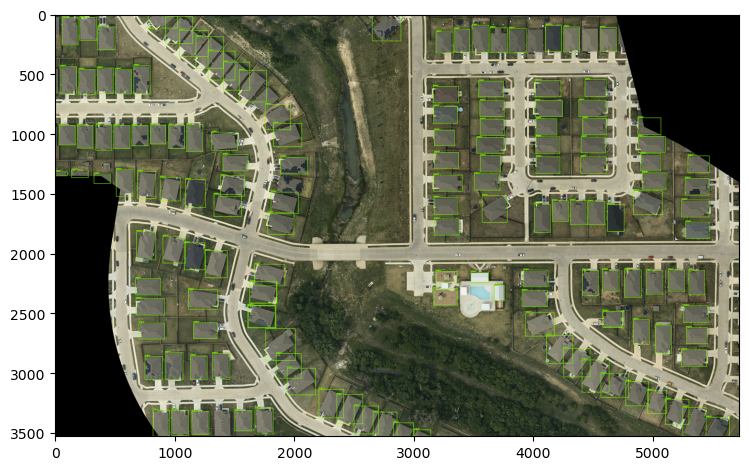

In [9]:
# select one file 
idx = 0

print(f"visulize file {train_filenames[idx]}")

image_np = train_images_np[idx]
boxes = train_gt_boxes[idx]
classes = train_class_labels[idx]
scores = np.ones(shape=boxes.shape[0], dtype=np.float32)

plt.figure(figsize=(30,15))
plt.subplot(2, 3, 1)

plot_detection(image_np, boxes, classes, scores = scores, category_index = category_index)

## Create model and restore weights for all but last layer

In [10]:
tf.keras.backend.clear_session()

pipeline_config = 'object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/pretrained_models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

In [11]:
# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(_feature_extractor=detection_model._feature_extractor,
                                           _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

In [12]:
# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!


## Custom training loop

In [13]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned
batch_size = 20
learning_rate = 0.01
num_batches = 100

/opt/anaconda3/envs/tfod/lib/python3.11/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [14]:
# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = ['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead', 
                    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

In [15]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""
    
    def train_step_fn(image_tensors, gt_boxes_list, gt_classes_list):
        """ A single training iteration

            Args:
                image_tensors:  a list of [height_in, width_in, channels] float tensor, len = batch_size 
                gt_boxes_list:
                gt_classes_list:
        """
    
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(groundtruth_boxes_list = gt_boxes_list, groundtruth_classes_list =gt_classes_list)
    
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat([model.preprocess(tf.expand_dims(image_tensor, axis = 0))[0] for image_tensor in image_tensors],axis = 0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
    
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
            
        return total_loss

    
    def valid_step_fn(image_tensors, gt_boxes_list, gt_classes_list):
        """ validate model 

            Args:
                image_tensors:  a list of [height_in, width_in, channels] float tensor, len = batch_size 
                gt_boxes_list:
                gt_classes_list:
        """
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(groundtruth_boxes_list = gt_boxes_list, groundtruth_classes_list =gt_classes_list)


        preprocessed_images = tf.concat([model.preprocess(tf.expand_dims(image_tensor, axis = 0))[0] for image_tensor in image_tensors],axis = 0)
        prediction_dict = model.predict(preprocessed_images, shapes)
        losses_dict = model.loss(prediction_dict, shapes)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']


        return total_loss
        

    return train_step_fn, valid_step_fn

In [20]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = learning_rate, momentum = 0.9)
train_step_fn, valid_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):

    # Grab a random subset of examples
    all_indices = list(range(len(train_images_np)))
    random.shuffle(all_indices)
    batch_indices = all_indices[0:batch_size]

    train_gt_boxes_list = [train_gt_box_tensors[idx] for idx in batch_indices]
    train_gt_classes_list = [train_gt_classes_one_hot_tensors[idx] for idx in batch_indices]
    train_image_tensors = [train_image_tensors[idx] for idx in batch_indices]

    # training
    total_trainingloss = train_step_fn(train_image_tensors, train_gt_boxes_list, train_gt_classes_list)

    if idx % 10 == 0 or idx == num_batches-1:
        
        # perform on validation files
        total_validateloss = valid_step_fn(valid_image_tensors, valid_gt_box_tensors, valid_gt_classes_one_hot_tensors)

        print('batch ' + str(idx+1) + ' of ' + str(num_batches) + 
              ',training loss=' +  str(total_trainingloss.numpy()) +
              ', validation loss=' +  str(total_validateloss.numpy()), 
              flush=True)

Start fine-tuning!
batch 1 of 100,training loss=0.62587214, validation loss=1.4483888
batch 11 of 100,training loss=0.77768314, validation loss=1.471089


KeyboardInterrupt: 

## Load test images and run inference with new model

In [ ]:
def obj_detect(model, input_tensor):
    """
        Args:
            input_tensor: [height, width, 3]
    """
    preprocessed_images, shapes = model.preprocess(tf.expand_dims(input_tensor, axis=0))
    prediction_dict = model.predict(preprocessed_images, shapes)
    postprocessed_dict = model.postprocess(prediction_dict, shapes)

    return postprocessed_dict

In [ ]:
test_image_dir = 'data/sample_data/roof/rawdata/test'
test_filenames = glob.glob(test_image_dir + '/*.tif')

for image_file in test_filenames:
    image_np = read_image_to_numpy(image_file)
    input_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)

    detections = obj_detect(model = detection_model, input_tensor=input_tensor)
    
    filename = os.path.basename(image_file)
    filename_prefix = filename.split('.')[0]

    plot_detection(image_np,
                   detections['detection_boxes'][0].numpy(), 
                   detections['detection_classes'][0].numpy().astype(np.int32) + label_id_offset,
                   detections['detection_scores'][0].numpy(),
                   category_index, 
                   min_score_thresh = 0.5,
                   figsize=(15, 20), 
                   image_name=os.path.join(test_image_dir, 'detected_'+ filename_prefix + '.jpg'))